# HomeWork 1 Problem 1

# Matthew Anderson | 801203905

# Github https://github.com/Mand187/Intro-to-ML


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

import time
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 1A

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 1.7045, Accuracy: 0.3892, Val Loss: 1.5161, Val Accuracy: 0.4687, Time: 11.36s
Epoch 2/20, Loss: 1.4443, Accuracy: 0.4903, Val Loss: 1.4072, Val Accuracy: 0.5008, Time: 11.54s
Epoch 3/20, Loss: 1.3233, Accuracy: 0.5342, Val Loss: 1.3673, Val Accuracy: 0.5191, Time: 11.58s
Epoch 4/20, Loss: 1.2334, Accuracy: 0.5636, Val Loss: 1.3641, Val Accuracy: 0.5185, Time: 11.53s
Epoch 5/20, Loss: 1.1570, Accuracy: 0.5882, Val Loss: 1.3316, Val Accuracy: 0.5296, Time: 12.67s
Epoch 6/20, Loss: 1.0905, Accuracy: 0.6106, Val Loss: 1.3525, Val Accuracy: 0.5412, Time: 11.23s
Epoch 7/20, Loss: 1.0222, Accuracy: 0.6350, Val Loss: 1.4054, Val Accuracy: 0.5309, Time: 11.62s
Epoch 8/20, Loss: 0.9651, Accuracy: 0.6549, Val Loss: 1.4190, Val Accuracy: 0.5325, Time: 11.51s
Epoch 9/20, Loss: 0.9070, Accuracy: 0.6747, Val Loss: 1.3853, Val Accuracy: 0.5384, Time: 11.57s
Epoch 10/20, 

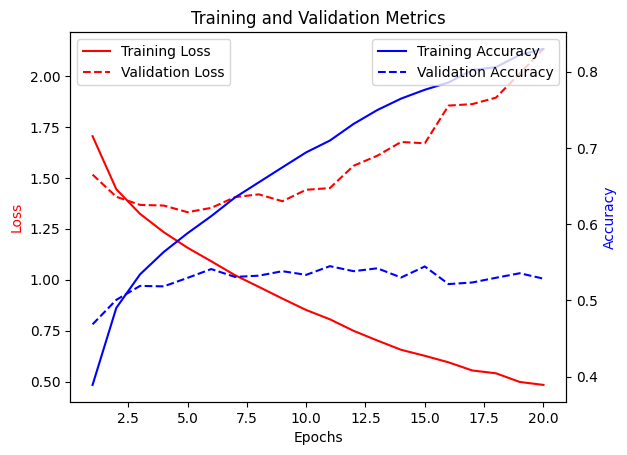

              precision    recall  f1-score   support

           0       0.54      0.65      0.59      1000
           1       0.68      0.58      0.63      1000
           2       0.42      0.45      0.44      1000
           3       0.37      0.35      0.36      1000
           4       0.40      0.47      0.43      1000
           5       0.45      0.43      0.44      1000
           6       0.59      0.57      0.58      1000
           7       0.60      0.60      0.60      1000
           8       0.66      0.67      0.66      1000
           9       0.65      0.52      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000

Test Accuracy: 0.5286


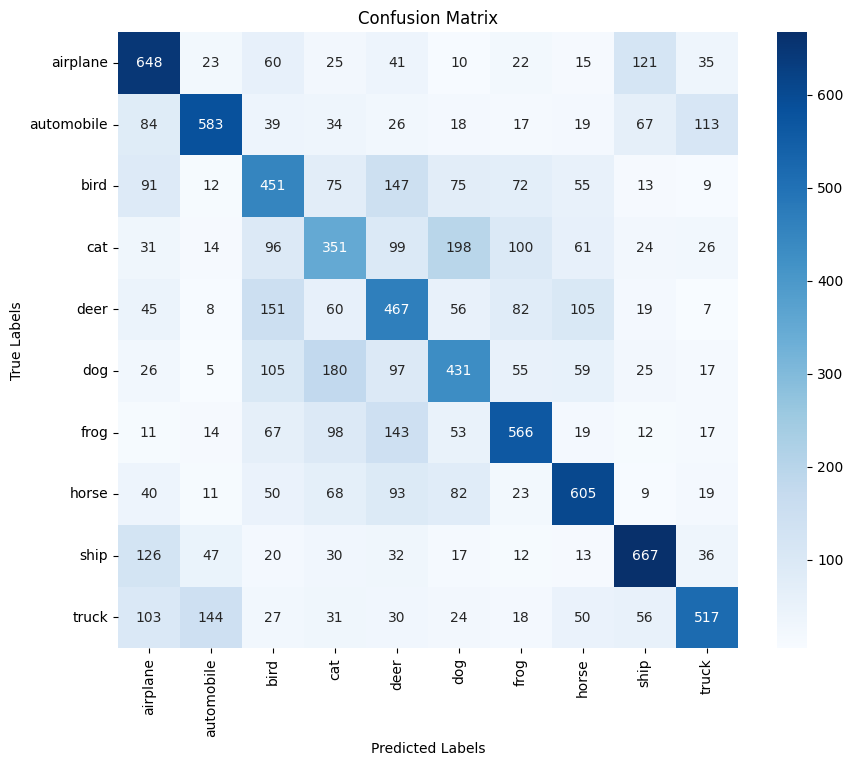

In [ ]:
def getMeanStd():
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    imgs = torch.stack([imgT for imgT, _ in dataset], dim=3)
    mean = imgs.view(3, -1).mean(dim=1)
    std = imgs.view(3, -1).std(dim=1)
    return mean, std

def getDataLoaders(mean, std, batchSize=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    trainDataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testDataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
    testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)

    return trainLoader, testLoader

class Cifar10Net(nn.Module):
    def __init__(self):
        super(Cifar10Net, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

def trainModel(model, trainLoader, testLoader, device, numEpochs=20, learningRate=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
    losses, accuracies = [], []
    val_losses, val_accuracies = [], []

    totalStartTime = time.time()

    for epoch in range(numEpochs):
        model.train()
        startTime = time.time()
        runningLoss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epochLoss = runningLoss / len(trainLoader)
        epochAcc = correct / total
        losses.append(epochLoss)
        accuracies.append(epochAcc)
        trainingTime = time.time() - startTime

        val_loss, val_acc = evaluateValidation(model, testLoader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{numEpochs}, Loss: {epochLoss:.4f}, Accuracy: {epochAcc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Time: {trainingTime:.2f}s')

    print(f'Total Training Time: {time.time() - totalStartTime:.2f} seconds')
    plotMetrics(losses, accuracies, val_losses, val_accuracies)
    printClassificationReport(model, testLoader, device)
    evaluateModel(model, testLoader, device)

def evaluateValidation(model, testLoader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(testLoader), correct / total

def evaluateModel(model, testLoader, device):
    model.eval()
    correct, total = 0, 0
    allPreds, allLabels = [], []

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            allPreds.extend(predicted.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    print(f'Test Accuracy: {correct / total:.4f}')
    plotConfusionMatrix(allLabels, allPreds)

def plotMetrics(losses, accuracies, val_losses, val_accuracies):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(range(1, len(losses)+1), losses, 'r-', label='Training Loss')
    ax1.plot(range(1, len(val_losses)+1), val_losses, 'r--', label='Validation Loss')
    ax2.plot(range(1, len(accuracies)+1), accuracies, 'b-', label='Training Accuracy')
    ax2.plot(range(1, len(val_accuracies)+1), val_accuracies, 'b--', label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy', color='b')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Training and Validation Metrics')
    plt.show()

def printClassificationReport(model, testLoader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Print the classification report
    print(classification_report(all_labels, all_preds))

def plotConfusionMatrix(labels, preds):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean, std = getMeanStd()
trainLoader, testLoader = getDataLoaders(mean, std)

model = Cifar10Net().to(device)
trainModel(model, trainLoader, testLoader, device)


# Problem 1B

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.0322, Accuracy: 0.2295, Val Loss: 1.7042, Val Accuracy: 0.3731, Time: 12.03s
Epoch 2/20, Loss: 1.6063, Accuracy: 0.4142, Val Loss: 1.4887, Val Accuracy: 0.4638, Time: 12.03s
Epoch 3/20, Loss: 1.4521, Accuracy: 0.4776, Val Loss: 1.4401, Val Accuracy: 0.4815, Time: 11.96s
Epoch 4/20, Loss: 1.3429, Accuracy: 0.5196, Val Loss: 1.4214, Val Accuracy: 0.4915, Time: 11.89s
Epoch 5/20, Loss: 1.2555, Accuracy: 0.5516, Val Loss: 1.3543, Val Accuracy: 0.5220, Time: 11.98s
Epoch 6/20, Loss: 1.1692, Accuracy: 0.5858, Val Loss: 1.3453, Val Accuracy: 0.5320, Time: 11.68s
Epoch 7/20, Loss: 1.0999, Accuracy: 0.6100, Val Loss: 1.3439, Val Accuracy: 0.5281, Time: 11.91s
Epoch 8/20, Loss: 1.0293, Accuracy: 0.6343, Val Loss: 1.3198, Val Accuracy: 0.5459, Time: 11.82s
Epoch 9/20, Loss: 0.9616, Accuracy: 0.6601, Val Loss: 1.3809, Val Accuracy: 0.5355, Time: 11.83s
Epoch 10/20, 

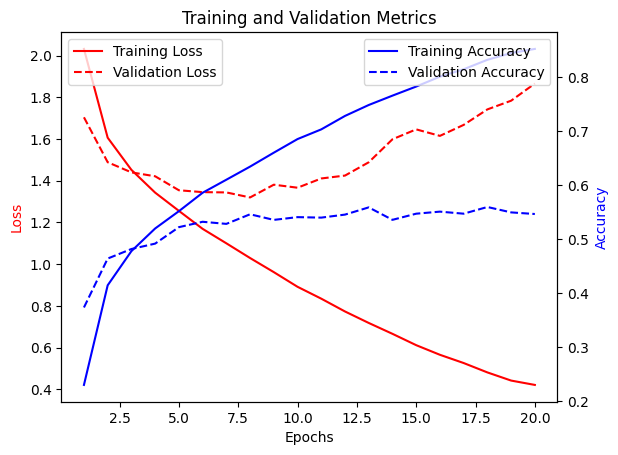

              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1000
           1       0.61      0.69      0.65      1000
           2       0.49      0.34      0.40      1000
           3       0.35      0.45      0.40      1000
           4       0.44      0.46      0.45      1000
           5       0.53      0.32      0.40      1000
           6       0.55      0.67      0.60      1000
           7       0.65      0.61      0.63      1000
           8       0.63      0.74      0.68      1000
           9       0.60      0.54      0.57      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.54     10000
weighted avg       0.55      0.55      0.54     10000

Test Accuracy: 0.5464


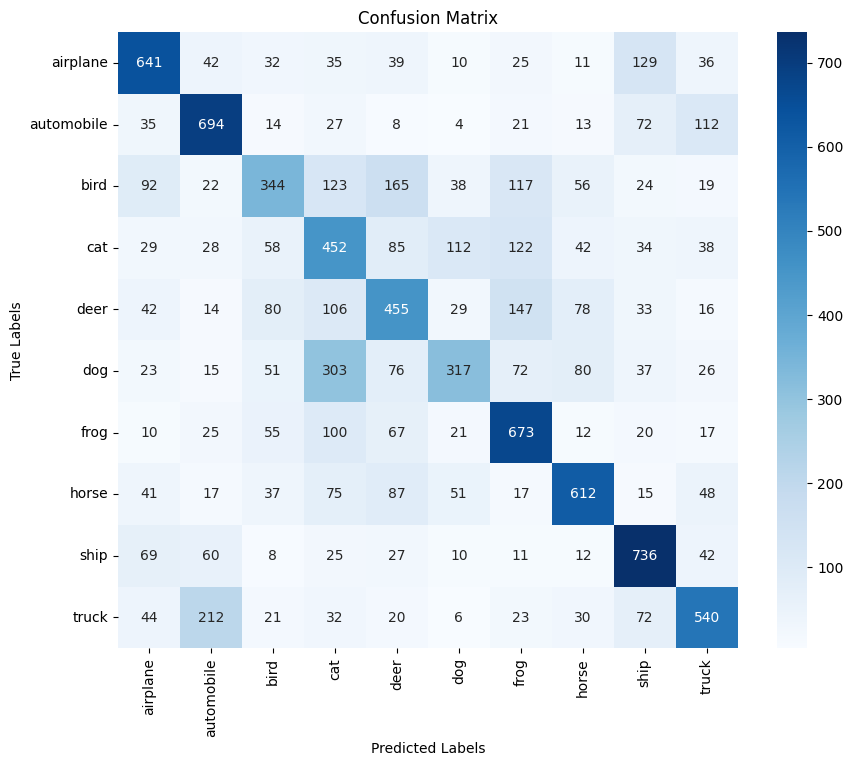

In [ ]:
class WiderDeeperCifar10Net(nn.Module):
    def __init__(self):
        super(WiderDeeperCifar10Net, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024), nn.ReLU(),  # Wider
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),       # Deeper
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.model(x)


# Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean, std = getMeanStd()
trainLoader, testLoader = getDataLoaders(mean, std)

model = WiderDeeperCifar10Net().to(device)
trainModel(model, trainLoader, testLoader, device)
